In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import notebook
import seaborn as sns
from ema_pytorch import EMA
from torch.distributions import Normal 
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [2]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""  
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed 
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
    """A fully connected layer that reshapes outputs to feature maps."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
#@title Set up the SDE
import functools
device = 'cpu' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma_min, sigma_max):
    """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.
    
    Args:    
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.  

    Returns:
    The standard deviation.
    """    
    t = torch.tensor(t)
    std = sigma_min * (sigma_max / sigma_min) ** t
    #torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))
    return std

def diffusion_coeff(t, sigma_min, sigma_max):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * torch.sqrt(torch.tensor(2 * (np.log(sigma_max) - np.log(sigma_min))))
    #torch.tensor(sigma**t)
    return diffusion
  
sigma_min = 0.01
sigma_max = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma_min=sigma_min, sigma_max = sigma_max)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma_min=sigma_min, sigma_max = sigma_max)

In [4]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a 
      time-dependent score-based model.
    x: A mini-batch of training data.    
    marginal_prob_std: A function that gives the standard deviation of 
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [12]:
#@title Training (double click to expand or collapse)

import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

n_epochs =   50#@param {'type':'integer'}
## size of a mini-batch
batch_size =  1000 #@param {'type':'integer'}
## learning rate
lr=1e-4 #@param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size)

optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.notebook.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-7-c1991806c254>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


KeyboardInterrupt: 

In [5]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  1000
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           num_steps=num_steps,
                           device='cpu',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

In [6]:
#@title Define the Predictor-Corrector sampler (double click to expand or collapse)

signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The number of sampling steps.
num_steps =  1000
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cpu',
               eps=1e-3):
  """Generate samples from score-based models with Predictor-Corrector method.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient
      of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in notebook.tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

    # The last step does not include any noise
    return x_mean

In [7]:
#@title Define the ODE sampler (double click to expand or collapse)

from scipy import integrate

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    init_x = z

  shape = init_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), init_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"Number of function evaluations: {res.nfev}")
  x = torch.tensor(res.y[:, -1], device=device).reshape(shape)

  return x


<ipython-input-3-366559729456>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


  0%|          | 0/500 [00:00<?, ?it/s]

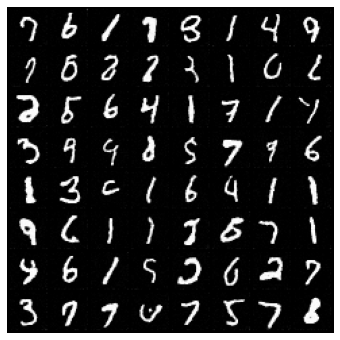

In [80]:
from torchvision.utils import make_grid


score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

ckpt = torch.load('MNIST.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 64 
sampler = pc_sampler 

samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device,
                 num_steps=500)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [116]:
data = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)

In [ ]:
data_sample = data[0]

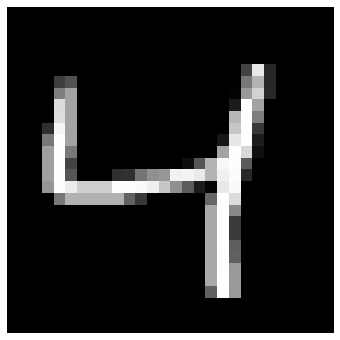

In [137]:
grid = make_grid(data[2][0], nrow=1)

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [81]:
def sde_VE(x, t, sigma_min, sigma_max):
    sigma = sigma_min * (sigma_max / sigma_min) ** t
    diffusion = sigma * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
    drift = 0
    return drift, diffusion

In [82]:
def get_diffused(obs, n, sde, sigma_min, sigma_max):
    data = obs.clone().detach()
    t = 1e-5
    dt = 1/n
    diffused = [data.clone().detach()]
    for i in range(n):
        drift, diffusion = sde(data, t, sigma_min, sigma_max)
        data += drift * dt
        data += diffusion * torch.randn(28,28, device=device) * np.sqrt(dt)
        data = torch.clamp(data, 0, 1)
        diffused.append(data.clone().detach())
        t += dt
        
    return torch.stack(diffused)

In [83]:
def insert_condition(x, y_obs):
    inserted = x.clone().detach()

    for i in inserted:
        i[0][:, :14] = y_obs

    return inserted

In [164]:
diff = get_diffused(data[2][0][0], 1000, sde_VE, sigma_min, sigma_max)

In [165]:
diff[0].shape

torch.Size([28, 28])

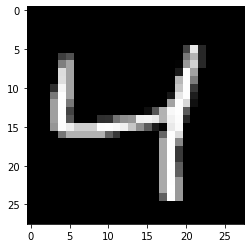

In [166]:
plt.imshow(make_grid(diff[0], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

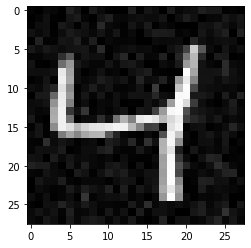

In [167]:
plt.imshow(make_grid(diff[250], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

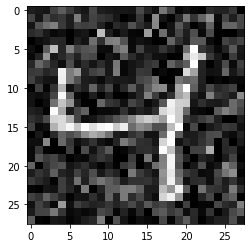

In [168]:
plt.imshow(make_grid(diff[400], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

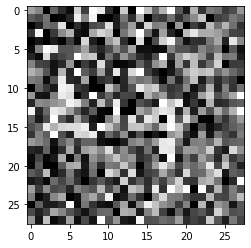

In [169]:
plt.imshow(make_grid(diff[500], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

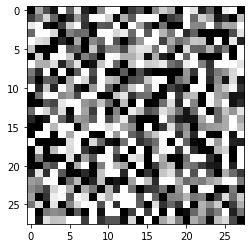

In [170]:
plt.imshow(make_grid(diff[750], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

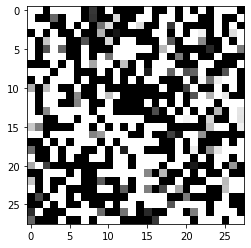

In [171]:
plt.imshow(make_grid(diff[1000], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [91]:
obs = diff[0][:,:14]

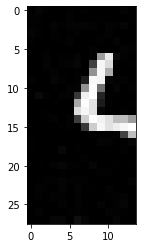

In [92]:
plt.imshow(make_grid(obs, nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

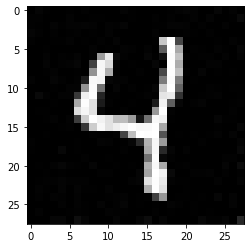

In [93]:
plt.imshow(make_grid(diff[0], nrow=1).permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [172]:
def CDiffE_Euler_Maruyama_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=16, 
                           num_steps=1000, 
                           eps=1e-5, sigma_min=sigma_min, sigma_max=sigma_max, diffused_y=None):

    t = torch.ones(batch_size, device=device)
    x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(1)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]

    if diffused_y is None:
        diffused_y = get_diffused(y_obs, 1000, sde_VE, sigma_min, sigma_max)
        diffused_y = [i[:,:14] for i in diffused_y]
    
    else:
        diffused_y = [i[:,:14] for i in diffused_y]

    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = insert_condition(x, y_obs_t)
            
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            

            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    return mean_x

In [173]:
def CDiffE_pc_sampler(score_model, 
                           marginal_prob_std,
                           diffusion_coeff, 
                           y_obs,
                           batch_size=16, 
                           num_steps=1000, 
                           eps=1e-5, sigma_min=sigma_min, sigma_max=sigma_max, diffused_y=None, snr=0.16):

    t = torch.ones(batch_size, device=device)
    x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(1)
    time_steps = torch.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]

    if diffused_y is None:
        diffused_y = get_diffused(y_obs, 1000, sde_VE, sigma_min, sigma_max)
        diffused_y = [i[:,:14] for i in diffused_y]
    
    else:
        diffused_y = [i[:,:14] for i in diffused_y]

    with torch.no_grad():
        for idx, time_step in enumerate(notebook.tqdm(time_steps)):
            idx = num_steps - idx - 1
            y_obs_t = diffused_y[idx]
            x = insert_condition(x, y_obs_t)
            batch_time_step = torch.ones(batch_size) * time_step
            
            # Corrector step (Langevin MCMC)
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            x = insert_condition(x, y_obs_t)
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    return mean_x

In [174]:
diff = get_diffused(data[2][0][0], 1000, sde_VE, sigma_min, sigma_max)

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-366559729456>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


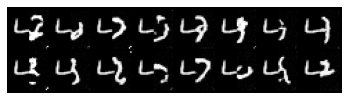

In [175]:
samples = CDiffE_Euler_Maruyama_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, samples[0][0], diffused_y = diff)


samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-3-366559729456>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)


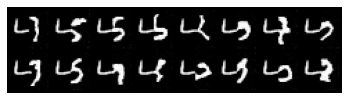

In [176]:
samples = CDiffE_pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn, samples[0][0], diffused_y = diff)


samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()